In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib.colors, os, sys
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
home_path = os.path.abspath(os.getcwd())
sys.path.append(home_path)
from functions import *
from GF_functions import *

In [2]:
# ---> physics params <---
c = 343 # m/s
v = 40000 # Hz
lam = c/v # m
dx_AMM = lam/2
k = 2*np.pi/lam # rads/m

# ---> simulation params <---
resolution = 4 
iterations = 200

# ---> AMM params <---
board_prop_dist = .2 # distance between board and AMM [m]
m, n = 32, 32 # Metasurface plane size (in units of dx_AMM)

In [3]:
# ---> build reflector plane <---
dx_AMM = lam/2
AMM_centrepoint = (0, 0, 0)
AMM_sidelengths = [(n*dx_AMM, n*dx_AMM), (m*dx_AMM, m*dx_AMM), (0, 0)]

AMM_points = points_vector_builder(AMM_centrepoint, AMM_sidelengths, dx_AMM)

# ---> evaluation plane <---
dx_eval = dx_AMM/resolution
eval_centrepoint = (3*lam, 0, 12*lam)
eval_sidelengths = [(n*dx_AMM, n*dx_AMM), (0, 0), (m*dx_AMM, m*dx_AMM)]

evaluation_points = points_vector_builder(eval_centrepoint, eval_sidelengths, dx_eval)

# ---> normals and areas <---
normals = [np.zeros((1, n*m)), np.zeros((1, n*m)), np.ones((1, n*m))]
areas = (dx_AMM**2)*np.ones((1, n*m))

coord_space_prop = [AMM_points, evaluation_points, normals, areas]

# define the complex pressure on the surface
phasemap = focus_phasemap_builder(AMM_points, eval_centrepoint, k)
AMM_surface_pressure = np.ones_like(phasemap)*np.exp(1j*phasemap)

# Build the propagator function
H = GF_propagator_function_builder(*coord_space_prop, k)

# propagate from reflector to evaluation plane
test_prop = GF_prop(AMM_surface_pressure, H, "forward")

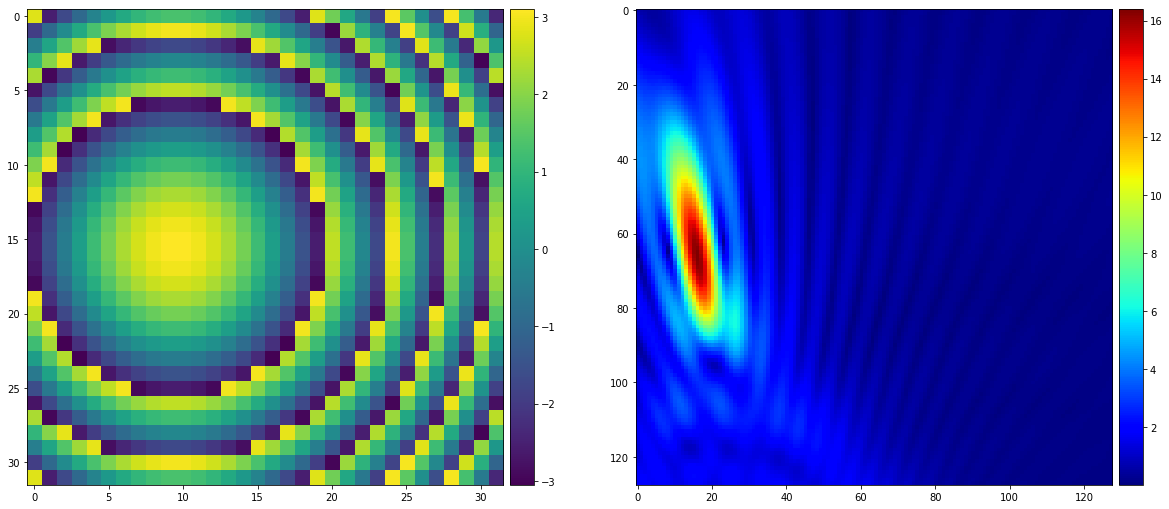

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

im = ax.flat[0].imshow(phasemap.reshape((m, n)))
divider = make_axes_locatable(ax.flat[0])
cax = divider.append_axes("right", size='5%', pad=.1)
plt.colorbar(im, cax=cax)

abs_prop_matrix = np.flipud(abs(test_prop).reshape((m*resolution, n*resolution)))

im = ax.flat[1].imshow(abs_prop_matrix, cmap=plt.get_cmap("jet"))
divider = make_axes_locatable(ax.flat[1])
cax = divider.append_axes("right", size='5%', pad=.1)
plt.colorbar(im, cax=cax)

plt.show()